# Importa Bibliotecas

In [1]:
# Bibliotecas principais
import numpy as np
import pandas as pd
import time
import pickle
from itertools import combinations
import warnings  # Gerenciamento de avisos

# Modelos e métricas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Estatísticas e testes de diagnóstico
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Gerenciamento de avisos
warnings.filterwarnings("ignore")  # Ignora avisos para manter o output limpo

# Funções

In [2]:
# Função para calcular o AIC de um modelo de Regressão Linear
def calculate_aic_linear(exog_comb):
    try:
        X = df_train[list(exog_comb)]
        y = df_train[target]
        model = LinearRegression().fit(X, y)
        n = len(y)
        residuals = y - model.predict(X)
        rss = np.sum(residuals ** 2)
        aic = n * np.log(rss / n) + 2 * len(exog_comb)  # Fórmula do AIC
        return aic, model
    except Exception as e:
        print(f"Erro ao ajustar o modelo de regressão linear para {exog_comb}: {e}")
        return np.inf, None


In [3]:
# Função para calcular o VIF de uma combinação de variáveis
def check_multicollinearity_linear(exog_comb, df_train):
    if len(exog_comb) < 2:  # Verifica se há pelo menos 2 variáveis na combinação
        return 0, pd.DataFrame()  # Retorna VIF 0 (nenhuma multicolinearidade possível)
    
    X = df_train[list(exog_comb)]
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data["VIF"].max(), vif_data  # Retorna o maior VIF e a tabela de VIFs

### Parâmetros

In [4]:
data_inicial = '20180101'
data_final = '20231201'

# define target
target = 'PD'

### Importa Bases

In [5]:
# 1. Carregar e preparar os dados
df = pd.read_parquet('base.parquet')

### Tratamento Base

In [6]:
# corte temporal
df = df[df['DATA_REFERENCIA'] >= data_inicial]
df = df[df['DATA_REFERENCIA'] <= data_final]

# definindo índice
df.set_index('DATA_REFERENCIA', inplace=True)

# Verificar as primeiras linhas
df.head()

,PD,IPCA_LAG_1,IPCA_LAG_3,IPCA_LAG_6,IPCA_LAG_12,DESEMPREGO_LAG_1,DESEMPREGO_LAG_3,DESEMPREGO_LAG_6,DESEMPREGO_LAG_12,PIB_LAG_1,...,PIB_LAG_6,PIB_LAG_12,SELIC_LAG_1,SELIC_LAG_3,SELIC_LAG_6,SELIC_LAG_12,CAMBIO_LAG_1,CAMBIO_LAG_3,CAMBIO_LAG_6,CAMBIO_LAG_12
DATA_REFERENCIA,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.861777,5.410274,5.159236,2.918972,4.657135,11.9,12.3,12.9,12.7,588892.8,...,557458.2,526564.7,6.675963,7.956187,10.033869,13.893348,3.291915,3.191229,3.206138,3.196609
2018-02-01,3.798198,3.536617,3.412864,2.303129,4.032747,12.3,12.1,12.7,13.3,555644.6,...,555578.7,514120.5,7.186373,7.058561,10.033869,10.954329,3.210609,3.259380,3.150917,3.104194
2018-03-01,3.815173,3.908738,5.410274,1.935750,3.040525,12.7,11.9,12.5,13.9,528905.5,...,528871.2,544312.9,5.788102,6.675963,7.956187,13.353730,3.241500,3.291915,3.134790,3.127930
2018-04-01,3.823845,1.084909,3.536617,5.159236,1.692904,13.2,12.3,12.3,13.7,560120.7,...,549304.7,525238.1,6.548709,7.186373,7.956187,9.902948,3.279214,3.210609,3.191229,3.136172
2018-05-01,3.876315,2.671660,3.908738,3.412864,3.784558,13.0,12.7,12.1,13.4,559359.8,...,566209.3,548887.7,6.421594,5.788102,7.058561,11.748906,3.407495,3.241500,3.259380,3.209509


### Separação Treino/Teste

In [7]:
# Separar em treino e teste
train_size = int(len(df) * 0.8)  
df_train = df.iloc[:train_size]
len(df_train)

57

In [8]:
test_size = len(df) - train_size
df_test = df.iloc[train_size:]
len(df_test)

15

## Modelo Regressão Linear

In [39]:
# Inicializar as variáveis para armazenar o melhor modelo
best_aic = np.inf
best_model = None
best_exog_comb = None

# Iniciar o processo backward stepwise
current_exog_vars = df_train.drop(columns=target).columns
while len(current_exog_vars) > 0:
    # Testar o AIC de cada combinação removendo uma variável de cada vez
    aic_with_removals = []
    models_with_removals = []
    
    for exog_comb in combinations(current_exog_vars, len(current_exog_vars) - 1):
        # Testar a multicolinearidade
        max_vif, vif_data = check_multicollinearity_linear(exog_comb, df_train)
        
        # Depuração: mostrar quais combinações estão sendo testadas
        print(f"Testando combinação: {exog_comb}, Maior VIF: {max_vif}")
        
        # Continuar apenas se não houver alta multicolinearidade
        if max_vif <= 5:  # Limite para alta multicolinearidade
            aic, model = calculate_aic_linear(exog_comb)
            aic_with_removals.append((aic, exog_comb))
            models_with_removals.append(model)
        else:
            print(f"Alta multicolinearidade detectada para {exog_comb}. Detalhes: \n{vif_data}")
    
    # Se não houver nenhuma combinação válida nesta etapa, apenas reduza o conjunto de variáveis
    if not aic_with_removals:
        print("Nenhuma combinação válida encontrada nesta etapa.")
        current_exog_vars = current_exog_vars[:-1]  # Remove uma variável arbitrária para continuar
        continue
    
    # Selecionar a combinação com o menor AIC
    best_aic_for_step, best_exog_for_step = min(aic_with_removals, key=lambda x: x[0])
    
    # Atualizar o melhor AIC e a melhor combinação de variáveis exógenas
    if best_aic_for_step < best_aic:
        best_aic = best_aic_for_step
        best_exog_comb = best_exog_for_step
        best_model = models_with_removals[aic_with_removals.index((best_aic_for_step, best_exog_for_step))]
        current_exog_vars = list(best_exog_comb)  # Atualizar para a melhor combinação
    else:
        # Caso não haja melhora no AIC, remova uma variável arbitrária e continue
        current_exog_vars = current_exog_vars[:-1]

# Resultado final
if best_model is not None:
    print(f"Melhor modelo encontrado com AIC: {best_aic} e variáveis: {best_exog_comb}")
else:
    print("Nenhum modelo válido foi encontrado.")

Testando combinação: ('IPCA_LAG_1', 'IPCA_LAG_3', 'IPCA_LAG_6', 'IPCA_LAG_12', 'DESEMPREGO_LAG_1', 'DESEMPREGO_LAG_3', 'DESEMPREGO_LAG_6', 'DESEMPREGO_LAG_12', 'PIB_LAG_1', 'PIB_LAG_3', 'PIB_LAG_6', 'PIB_LAG_12', 'SELIC_LAG_1', 'SELIC_LAG_3', 'SELIC_LAG_6', 'SELIC_LAG_12', 'CAMBIO_LAG_1', 'CAMBIO_LAG_3', 'CAMBIO_LAG_6'), Maior VIF: 1534.3815862583908
Alta multicolinearidade detectada para ('IPCA_LAG_1', 'IPCA_LAG_3', 'IPCA_LAG_6', 'IPCA_LAG_12', 'DESEMPREGO_LAG_1', 'DESEMPREGO_LAG_3', 'DESEMPREGO_LAG_6', 'DESEMPREGO_LAG_12', 'PIB_LAG_1', 'PIB_LAG_3', 'PIB_LAG_6', 'PIB_LAG_12', 'SELIC_LAG_1', 'SELIC_LAG_3', 'SELIC_LAG_6', 'SELIC_LAG_12', 'CAMBIO_LAG_1', 'CAMBIO_LAG_3', 'CAMBIO_LAG_6'). Detalhes: 
             variable          VIF
0          IPCA_LAG_1     4.365893
1          IPCA_LAG_3     5.153723
2          IPCA_LAG_6     6.269466
3         IPCA_LAG_12     4.317517
4    DESEMPREGO_LAG_1  1509.880144
5    DESEMPREGO_LAG_3  1345.218244
6    DESEMPREGO_LAG_6   600.381714
7   DESEMPREGO_

In [41]:
# Definir as variáveis explicativas com um termo constante para o intercepto
X = df_train[list(best_exog_comb)]
X = sm.add_constant(X)  # Adiciona uma coluna de 1's para o intercepto

# Ajustar o modelo com statsmodels
model = sm.OLS(df_train[target], X).fit()

# Ver o sumário do modelo com coeficientes, p-valores e mais
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PD   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     10.52
Date:                Sat, 04 Jan 2025   Prob (F-statistic):           0.000139
Time:                        09:18:18   Log-Likelihood:                 11.587
No. Observations:                  57   AIC:                            -17.17
Df Residuals:                      54   BIC:                            -11.04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5934      0.045     79.360      0.0

### Multicolinearidade

In [42]:
# Criar o DataFrame das variáveis independentes (com constante incluída)
X_vif = sm.add_constant(df_train[list(best_exog_comb)])

# Calcular o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["Variável"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

     Variável       VIF
0       const  2.839539
1  IPCA_LAG_1  1.072123
2  IPCA_LAG_3  1.072123


### Predições em Treino

In [12]:
# Adiciona uma constante ao conjunto de variáveis exógenas
X_train_const = sm.add_constant(df_train[list(best_exog_comb)])

# Faz a previsão usando o modelo ajustado
y_pred_train = model.predict(X_train_const)

### R2 em Treino

In [13]:
# Calcule o R² e o R² ajustado
n = len(df_train)
p = len(best_exog_comb) # Número de variáveis exógenas
r2 = r2_score(df_train[target], y_pred_train)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R²: {r2}")
print(f"R² ajustado: {adjusted_r2}")

R²: 0.28040011335631354
R² ajustado: 0.2537482657028436


### Predições em Teste

In [14]:
# Adiciona uma constante ao conjunto de variáveis exógenas
X_test_const = sm.add_constant(df_test[list(best_exog_comb)])

# Faz a previsão usando o modelo ajustado
y_pred_test = model.predict(X_test_const)

### Análise dos Resíduos



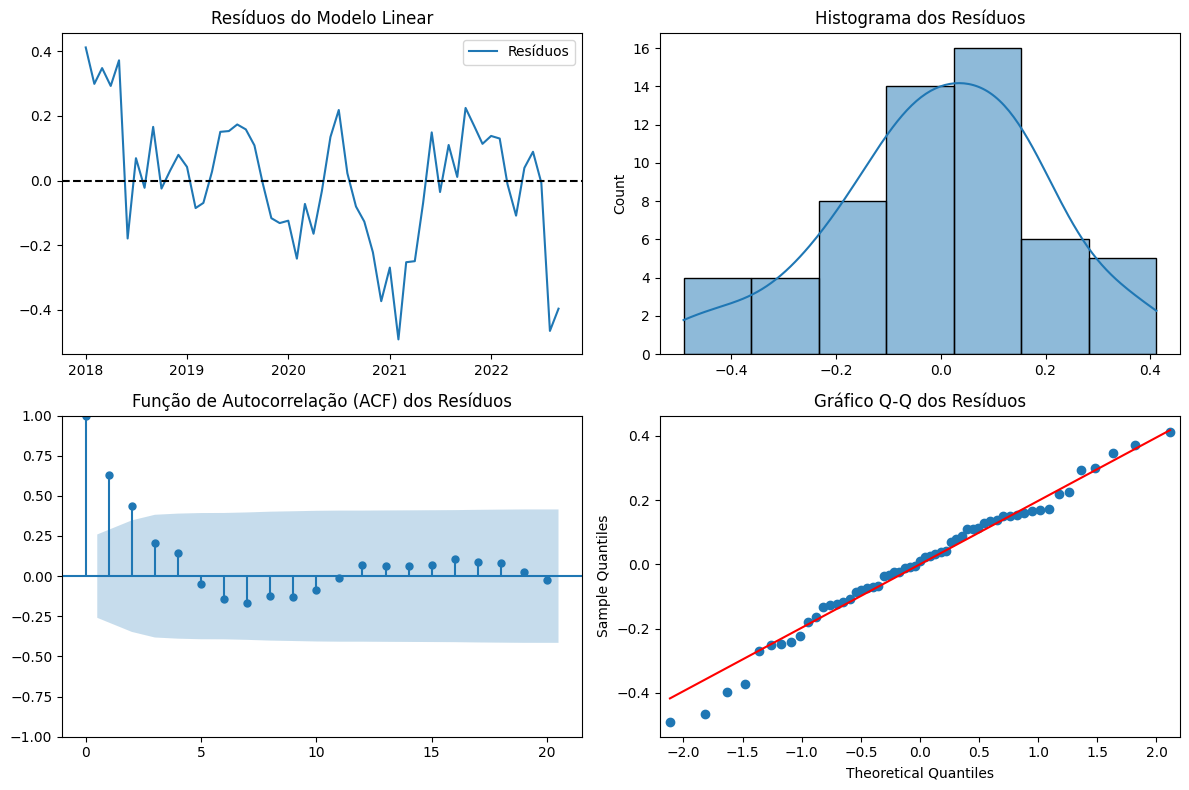


Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: 1.1469
   - p-valor: 0.5636
   Os resíduos seguem uma distribuição normal.

2. Teste de Ljung-Box (lag 10):
   - Estatística: 45.3323
   - p-valor: 0.0000
   Há autocorrelação significativa nos resíduos.

3. Teste de Breusch-Pagan:
   - Estatística LM: 3.9154
   - p-valor LM: 0.1412
   - Estatística F: 1.9915
   - p-valor F: 0.1464
   Os resíduos possuem variância constante (homocedasticidade).



In [43]:
# Calculando os resíduos manualmente
y_true = df_train[target]
y_pred = y_pred_train
residuos = y_true - y_pred  # Cálculo dos resíduos

# Ajustando o erro no teste Jarque-Bera
jb_stat, jb_pvalue = jarque_bera(residuos)

# Teste Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

# Teste de Breusch-Pagan
X = sm.add_constant(df_train[list(best_exog_comb)])  # Variáveis explicativas originais + constante
bp_test = het_breuschpagan(residuos, X)
bp_stat, bp_pvalue, bp_f_stat, bp_f_pvalue = bp_test

# Criando os gráficos
plt.figure(figsize=(12, 8))

# Gráfico de resíduos
plt.subplot(2, 2, 1)
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo Linear')
plt.legend()

# Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

# ACF dos resíduos
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuos, ax=plt.gca(), lags=20)
plt.title('Função de Autocorrelação (ACF) dos Resíduos')

# Q-Q plot
plt.subplot(2, 2, 4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title('Gráfico Q-Q dos Resíduos')

plt.tight_layout()
plt.show()

# Interpretando os resultados
interpretation = f"""
Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: {jb_stat:.4f}
   - p-valor: {jb_pvalue:.4f}
   {'Os resíduos seguem uma distribuição normal.' if jb_pvalue > 0.05 else 'Os resíduos não seguem uma distribuição normal.'}

2. Teste de Ljung-Box (lag 10):
   - Estatística: {ljung_box_test['lb_stat'].values[0]:.4f}
   - p-valor: {ljung_box_test['lb_pvalue'].values[0]:.4f}
   {'Não há autocorrelação significativa nos resíduos.' if ljung_box_test['lb_pvalue'].values[0] > 0.05 else 'Há autocorrelação significativa nos resíduos.'}

3. Teste de Breusch-Pagan:
   - Estatística LM: {bp_stat:.4f}
   - p-valor LM: {bp_pvalue:.4f}
   - Estatística F: {bp_f_stat:.4f}
   - p-valor F: {bp_f_pvalue:.4f}
   {'Os resíduos possuem variância constante (homocedasticidade).' if bp_pvalue > 0.05 else 'Os resíduos apresentam heterocedasticidade (variância não constante).'}
"""

print(interpretation)

### Vizualização Gráfica

### Predições em Teste

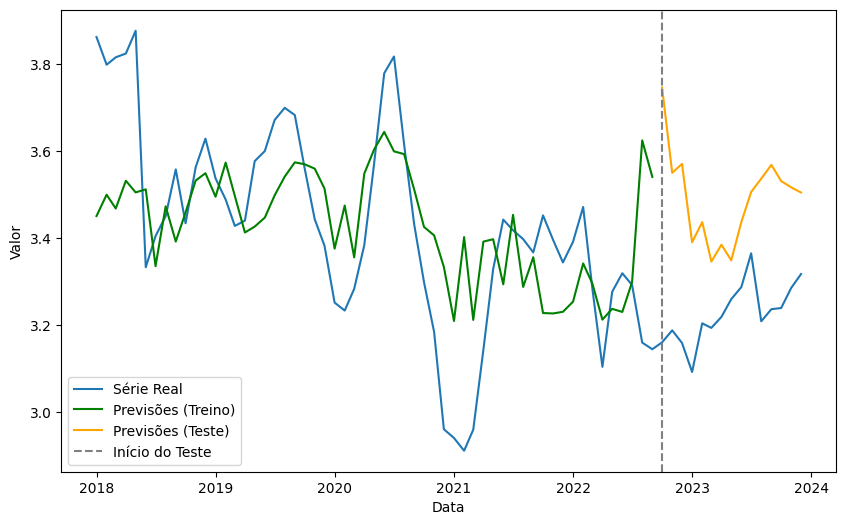

In [44]:
# Converter as previsões em séries temporais com o mesmo índice dos dados de treino e teste
y_pred_train_series = pd.Series(y_pred_train, index=df_train.index, name='Previsões (Treino)')
y_pred_test_series = pd.Series(y_pred_test, index=df_test.index, name='Previsões (Teste)')

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target], label='Série Real')
plt.plot(y_pred_train_series.index, y_pred_train_series, label='Previsões (Treino)', color='green')
plt.plot(y_pred_test_series.index, y_pred_test_series, label='Previsões (Teste)', color='orange')
plt.axvline(x=df_test.index[0], color='gray', linestyle='--', label='Início do Teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Métricas em Treino

In [45]:
# Remover o primeiro valor de fitted_values para alinhar as séries 
fitted_values_aligned = y_pred_train.values
actual_values = df_train[target].values


rmse_arima_train = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_train = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_train = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_train}')
print(f'MAE: {mae_arima_train}')
print(f"MAPE: {mape_arima_train:.2f}%")

RMSE: 0.19746029910859839
MAE: 0.1554425513145933
MAPE: 4.60%


### Métricas em Teste

In [46]:
# Remover o primeiro valor de fitted_values para alinhar as séries (percorrendo combinações com 5 variáveis)
fitted_values_aligned = y_pred_test.values
actual_values = df_test[target].values


rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")

RMSE: 0.29215140629374425
MAE: 0.2640302629527775
MAPE: 8.23%


### Salvando modelo

In [18]:
# Nome do arquivo onde o modelo será salvo
model_filename = 'modelo_linear.pkl'

# Salvando o modelo em um arquivo pickle
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: modelo_linear.pkl
